## **1.Subtask 1 - Polarization detection**


### **1.1 Imports**

In [1]:
#!unzip dev_phase.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -qq optuna

In [4]:
!pip install iterative-stratification

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import random
from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

import os
import zipfile
from typing import Dict

import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

In [7]:
from transformers import set_seed
def set_global_seed(seed: int = 42):
    """
    Set seed for reproducibility across Python, NumPy, PyTorch, and Hugging Face Transformers.

    Args:
        seed (int): Seed value to use.
    """


    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # CUDNN settings for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hugging Face Transformers
    set_seed(seed)

    print(f"[INFO] Global seed set to {seed}")


In [8]:
set_global_seed(42)

[INFO] Global seed set to 42


### 1.2 Data Import

In [9]:
# Load the training and validation data for subtask 1

train_eng = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/eng.csv')
train_hau = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/hau.csv')


train_eng, val_eng = train_test_split(
    train_eng,
    test_size=0.1,
    shuffle=True,
    stratify=train_eng['polarization'],
    random_state=40
)

train_hau, val_hau = train_test_split(
    train_hau,
    test_size=0.1,
    shuffle=True,
    stratify=train_hau['polarization'],
    random_state=40
)



train = pd.concat([train_eng, train_hau], ignore_index=True)
val = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/eng.csv')
dev_set_hau=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/hau.csv')


train.head()

,id,text,polarization
0,eng_54dde3b05be9510ecb5a32e59c3f5654,NATO has taken over coordination of Western mi...,0
1,eng_ca99e417ba56c186664ad50b13aee3bf,"TRUMP LIE 718 ""Not statistically possible. Rig...",1
2,eng_2e927c0378772abd03b9d9dfe77cdd3d,Russians didnt kill anyone in Ukraine invasion,0
3,eng_928a32380ac569d1dc82cb13c477e07f,Kamala Harris is the funniest person Kamala Ha...,0
4,eng_702a151aa2145b678a2379320dbd604b,"Mike Pence R, IN Norm Coleman R, MN",0


### **1.3 Dataset**


##### ***1.3.1 Labelled Dataset***

In [10]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset_T1(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

##### ***1.3.2 Unlabelled Dataset***

In [11]:
class Unlabelled_PolarizationDataset_T1(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=[0 for  l in labels]
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

#### **1.3.3 Tokenization**

In [12]:
# Load the tokenizer
tokenizer_task1 = AutoTokenizer.from_pretrained('microsoft/mdeberta-v3-base')

#making data_sets
train_dataset_t1 = PolarizationDataset_T1(train['text'].tolist(), train['polarization'].tolist(), tokenizer_task1)
val_dataset_t1 = PolarizationDataset_T1(val['text'].tolist(), val['polarization'].tolist(), tokenizer_task1)


dev_dataset_eng_t1 = Unlabelled_PolarizationDataset_T1(dev_set_eng['text'].tolist(), dev_set_eng['polarization'].tolist(), tokenizer_task1)
dev_dataset_hau_t1 = Unlabelled_PolarizationDataset_T1(dev_set_hau['text'].tolist(), dev_set_hau['polarization'].tolist(), tokenizer_task1)




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### **1.4 Model Training**

#### **1.4.1 Model Initialization**

In [13]:
model_task1 = AutoModelForSequenceClassification.from_pretrained('microsoft/mdeberta-v3-base', num_labels=2)

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **1.4.2 Metrics Function**

In [14]:
# function to compute metrics
def compute_custom_metrics_task1(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision_macro = precision_score(labels, preds, average='macro', zero_division=0)
    recall_macro = recall_score(labels, preds, average='macro', zero_division=0)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)
    f1_micro = f1_score(labels, preds, average='micro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }


#### **1.4.3  Model Parameters**

In [15]:
# Define training arguments
training_args_t1 = TrainingArguments(
        output_dir=f"./",
        num_train_epochs=4,
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        seed=42,
        weight_decay=0.01,
        warmup_ratio=0.1,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        disable_tqdm=False
    )


#### **1.4.4 Model Trainer**

In [16]:
# Initialize the Trainer
trainer_task1 = Trainer(
    model=model_task1,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args_t1,                  # training arguments, defined above
    train_dataset=train_dataset_t1,         # training dataset
    eval_dataset=val_dataset_t1,            # evaluation dataset
    compute_metrics=compute_custom_metrics_task1,     # the callback that computes metrics of interest
    data_collator=DataCollatorWithPadding(tokenizer_task1) # Data collator for dynamic padding
)

# Train the model
trainer_task1.train()

# Evaluate the model on the validation set
eval_results = trainer_task1.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,F1 Micro
1,0.409800,0.397933,0.854862,0.792747,0.800506,0.796491,0.854862
2,0.348900,0.421095,0.873730,0.822301,0.814969,0.818531,0.873730
3,0.289400,0.566871,0.862119,0.801677,0.818675,0.809545,0.862119
4,0.144900,0.650522,0.859216,0.809928,0.769653,0.786556,0.859216


Macro F1 score on validation set: 0.7865558241807376


#### **1.4.6 Test on dev set**

In [17]:
pred_data_t1 = {
    "eng": {'data': dev_dataset_eng_t1, 'ids': dev_set_eng['id'].tolist()},
    "hau": {'data': dev_dataset_hau_t1, 'ids': dev_set_hau['id'].tolist()},
}

for lang in pred_data_t1:
    pred_dev=trainer_task1.predict(pred_data_t1[lang]['data'])
    y_pred = np.argmax(pred_dev.predictions, axis=1)
    y_true = pred_dev.label_ids
    pred_data_t1[lang]['results']=y_pred

#### **1.4.7 Making Submission Package**

In [9]:
# --- Helper: Save a single prediction CSV ---
def save_prediction_csv(df: pd.DataFrame, lang_code: str, folder: str):
    """Save a DataFrame as a csv."""
    file_path = os.path.join(folder, f"pred_{lang_code}.csv")
    df.to_csv(file_path, index=False)
    return file_path

# --- Helper: Zip a folder ---
def zip_folder(folder_path: str, zip_path: str):
    """Create a zip file of the folder."""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                zipf.write(file_path, arcname)

# --- Main function: Create submission zip ---
def create_submission_zip(task,predictions: Dict[str, pd.DataFrame], output_dir=".",):
    """
    function to create submission zip for Subtask.
    """
    zip_name=f"{task}.zip"
    # Folder for submission files
    submission_folder = os.path.join(output_dir, task)
    os.makedirs(submission_folder, exist_ok=True)

    # Save each prediction CSV
    for lang_code, df in predictions.items():
        save_prediction_csv(df, lang_code, submission_folder)

    # Create zip
    zip_path = os.path.join(output_dir, zip_name)
    zip_folder(submission_folder, zip_path)
    print(f"Submission zip created at: {zip_path}")


In [19]:
submission_dict = {}

for lang in pred_data_t1:
    df = pd.DataFrame({
        "id": pred_data_t1[lang]['ids'],
        "polarization": pred_data_t1[lang]['results']
    })
    submission_dict[lang] = df

create_submission_zip('subtask_1',submission_dict)

Submission zip created at: ./subtask_1.zip


#### **1.4.8 Saving the Model**

In [20]:
from datetime import datetime

In [21]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='mdeberta-v3-base'
save_path = f"saved_model_t1_{naming}_f1_{eval_results['eval_f1_macro']:.4f}_{timestamp}"
trainer_task1.save_model('drive/MyDrive/NLP/models'+'//'+save_path)

### **Confusion Matrix**

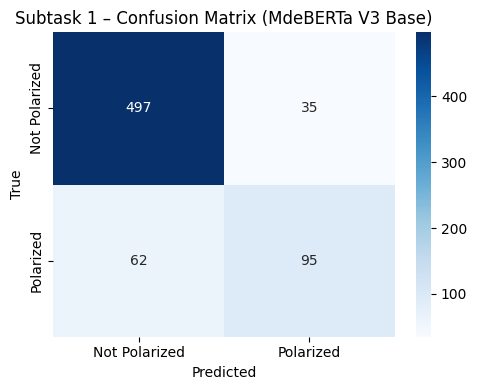

In [22]:
# Get predictions on validation set
val_preds_t1 = trainer_task1.predict(val_dataset_t1)

y_true_t1 = val_preds_t1.label_ids
y_pred_t1 = np.argmax(val_preds_t1.predictions, axis=1)

# Confusion matrix
cm_t1 = confusion_matrix(y_true_t1, y_pred_t1)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_t1,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Polarized", "Polarized"],
    yticklabels=["Not Polarized", "Polarized"]
)
naming='MdeBERTa V3 Base'
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Subtask 1 – Confusion Matrix ({naming})")
plt.tight_layout()
plt.savefig(f'drive/MyDrive/NLP/{naming}_t1.pdf',format='pdf',dpi=300)
plt.show()

# **2.Subtask 2: Polarization Type Classification**

### **2.1 Data Import**

In [10]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def multilabel_split(df, labels, test_size=0.1, seed=40):
    splitter = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=seed
    )
    X = df.index.values
    y = df[labels].values

    for train_idx, val_idx in splitter.split(X, y):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

    return train_df, val_df

In [25]:

train_eng = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/eng.csv')
train_hau = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/hau.csv')

labels = ['gender/sexual','political','religious','racial/ethnic','other']
train_eng, val_eng = multilabel_split(train_eng, labels)
train_hau, val_hau = multilabel_split(train_hau, labels)


train_t2 = pd.concat([train_eng, train_hau], ignore_index=True)
val_t2 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/eng.csv')
dev_set_hau_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/hau.csv')

train_t2.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0


### **2.2 Dataset**

#### **2.2.1 Labelled Dataset**

In [26]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset_t2(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels

        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}

        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


#### **2.2.2 Unlabelled Dataset**

In [27]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class Unlabelled_PolarizationDataset_t2(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = [[0, 0, 0, 0, 0] for i in labels]

        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}

        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


#### **2.2.3 Tokenization**

In [28]:
# Load the tokenizer
tokenizer_task2 = AutoTokenizer.from_pretrained('microsoft/mdeberta-v3-base')

# Create train and Test dataset for multilabel
train_dataset_t2 = PolarizationDataset_t2(train_t2['text'].tolist(), train_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)
val_dataset_t2 = PolarizationDataset_t2(val_t2['text'].tolist(), val_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)

dev_dataset_eng_t2 = Unlabelled_PolarizationDataset_t2(dev_set_eng_t2['text'].tolist(), dev_set_eng_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)
dev_dataset_hau_t2 = Unlabelled_PolarizationDataset_t2(dev_set_hau_t2['text'].tolist(), dev_set_hau_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### **2.3 Model Training**

#### **2.3.1 Model Initialization**

In [29]:
# Load the model suitabled for  5 labels
model_task2 = AutoModelForSequenceClassification.from_pretrained('microsoft/mdeberta-v3-base', num_labels=5, problem_type="multi_label_classification")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **2.3.2 Metrics Function**

In [30]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel_task2(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}



#### **2.3.3  Model Parameters**

In [31]:
# Define training arguments
training_args_task2 = TrainingArguments(
        output_dir=f"./",
        num_train_epochs=4,
        learning_rate=4e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        seed=42,
        weight_decay=0.01,
        warmup_ratio=0.1,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        disable_tqdm=False
    )

#### **2.3.4 Model Trainer**

In [32]:
# Initialize the Trainer
trainer_task2 = Trainer(
    model=model_task2,
    args=training_args_task2,
    train_dataset=train_dataset_t2,
    eval_dataset=val_dataset_t2,
    compute_metrics=compute_metrics_multilabel_task2,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer_task2)
)

# Train the model
trainer_task2 .train()

# Evaluate the model on the validation set
eval_results = trainer_task2 .evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.160500,0.181252,0.088442
2,0.141500,0.161762,0.172754
3,0.123000,0.155434,0.209243
4,0.095000,0.162976,0.261905


Macro F1 score on validation set for Subtask 2: 0.26190476190476186


#### **2.3.5 Test on dev set**

In [33]:
from scipy.special import expit

In [34]:
pred_data_t2 = {
    "eng": {'data': dev_dataset_eng_t2, 'ids': dev_set_eng_t2['id'].tolist()},
    "hau": {'data': dev_dataset_hau_t2, 'ids': dev_set_hau_t2['id'].tolist()},
}

for lang in pred_data_t2:
    pred_dev=trainer_task2.predict(pred_data_t2[lang]['data'])

    #converting logits to probabilities using sigmoid
    probs = expit(pred_dev.predictions)

    y_pred = (probs > 0.5).astype(int)

    y_true = pred_dev.label_ids
    pred_data_t2[lang]['results']=y_pred



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **2.3.6 Making Submission Package**

In [35]:
submission_dict = {}

for lang in pred_data_t2:
    df = pd.DataFrame({
        "id": pred_data_t2[lang]['ids'],
        'gender/sexual':pred_data_t2[lang]['results'][:,0],
        'political':pred_data_t2[lang]['results'][:,1],
        'religious':pred_data_t2[lang]['results'][:,2],
        'racial/ethnic':pred_data_t2[lang]['results'][:,3],
        'other':pred_data_t2[lang]['results'][:,4]
    })
    submission_dict[lang] = df

create_submission_zip('subtask_2',submission_dict)

Submission zip created at: ./subtask_2.zip


#### **2.3.7 Saving the Model**

In [36]:
from datetime import datetime

In [37]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='mdeberta-v3-base'
save_path = f"saved_model_t2_{naming}_f1_{eval_results['eval_f1_macro']:.4f}_{timestamp}"
trainer_task2.save_model('drive/MyDrive/NLP/models'+'//'+save_path)

### **Confusion Matrix**

In [25]:
def plot_label_confusion_matrix_multilabel(
    y_true,
    y_pred,
    label_names,
    naming,
    title
):
    n_labels = len(label_names)
    matrix = np.zeros((n_labels, n_labels), dtype=int)

    for i in range(n_labels):
        for j in range(n_labels):
            matrix[i, j] = np.sum(
                (y_true[:, i] == 1) & (y_pred[:, j] == 1)
            )

    plt.figure(figsize=(7,6))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

    plt.tight_layout()
    plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
    plt.show()


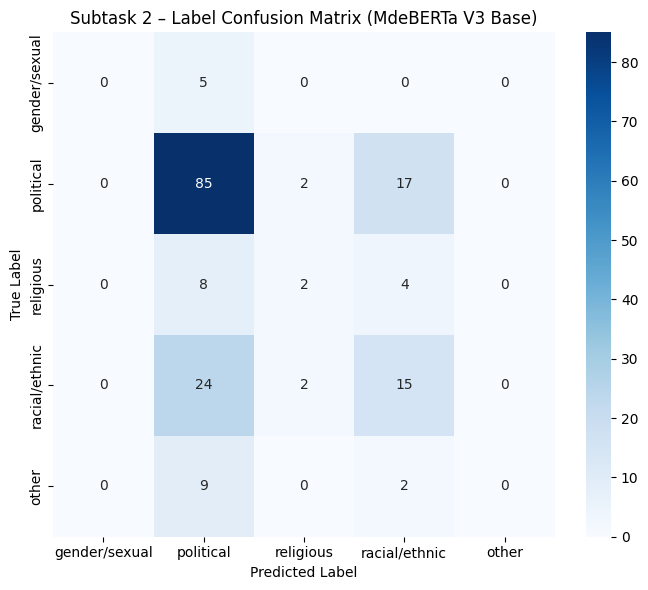

In [39]:
# Validation predictions
val_preds_t2 = trainer_task2.predict(val_dataset_t2)

# Sigmoid + threshold
probs_t2 = torch.sigmoid(torch.from_numpy(val_preds_t2.predictions))
y_pred_t2 = (probs_t2 > 0.5).int().numpy()
y_true_t2 = val_preds_t2.label_ids

labels_t2 = ['gender/sexual','political','religious','racial/ethnic','other']
naming='MdeBERTa_V3_Base_t3'
title='MdeBERTa V3 Base'
plot_label_confusion_matrix_multilabel(
    y_true_t2,
    y_pred_t2,
    labels_t2,
    naming,
    title=f"Subtask 2 – Label Confusion Matrix ({title})"
)


# 3.Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



### **3.1 Data Import**

In [11]:

train_eng = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/eng.csv')
train_hau = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/hau.csv')

labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']
train_eng, val_eng = multilabel_split(train_eng, labels)
train_hau, val_hau = multilabel_split(train_hau, labels)


train_t3 = pd.concat([train_eng, train_hau], ignore_index=True)
val_t3 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/eng.csv')
dev_set_hau_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/hau.csv')


train_t3.head()

,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0,0


### **3.2 Dataset**

#### **3.2.1 Labelled Dataset**

In [12]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset_t3(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

#### **3.2.1 UnLabelled Dataset**

In [13]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class UnlabelledPolarizationDataset_t3(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = [[0,0,0,0,0,0] for i in labels]
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

#### **3.2.2 Tokenization**

In [14]:
# Load the tokenizer
tokenizer_task3 = AutoTokenizer.from_pretrained('microsoft/mdeberta-v3-base')

# Create train and Test dataset for multilabel
train_dataset_t3 = PolarizationDataset_t3(train_t3['text'].tolist(), train_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)
val_dataset_t3 = PolarizationDataset_t3(val_t3['text'].tolist(), val_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)

dev_dataset_eng_t3 = UnlabelledPolarizationDataset_t3(dev_set_eng_t3['text'].tolist(), dev_set_eng_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)
dev_dataset_hau_t3 = UnlabelledPolarizationDataset_t3(dev_set_hau_t3['text'].tolist(), dev_set_hau_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

### **3.3 Model Training**

#### **3.3.1 Model Initialization**

In [15]:
# Load the model
model_task3 = AutoModelForSequenceClassification.from_pretrained('microsoft/mdeberta-v3-base', num_labels=6, problem_type="multi_label_classification") # use 6 labels

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **3.3.2 Metrics Function**

In [16]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel_task3(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

#### **3.3.3  Model Parameters**

In [17]:
# Define training arguments
training_args_t3 = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=6,
    learning_rate=4e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)



#### **3.3.4 Model Trainer**

In [18]:
# Initialize the Trainer
trainer_task3 = Trainer(
    model=model_task3,
    args=training_args_t3,
    train_dataset=train_dataset_t3,
    eval_dataset=val_dataset_t3,
    compute_metrics=compute_metrics_multilabel_task3,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer_task3)
)

# Train the model
trainer_task3.train()

# Evaluate the model on the validation set
eval_results = trainer_task3.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.231500,0.252994,0.081081
2,0.236400,0.231936,0.164066
3,0.210000,0.258099,0.233212
4,0.163300,0.311956,0.169302
5,0.158700,0.333062,0.223029
6,0.150600,0.300146,0.297145


Macro F1 score on validation set for Subtask 3: 0.2971450719755948


#### **3.3.5 Test on dev set**

In [19]:
from scipy.special import expit

In [20]:
pred_data_t3 = {
    "eng": {'data': dev_dataset_eng_t3, 'ids': dev_set_eng_t3['id'].tolist()},
    "hau": {'data': dev_dataset_hau_t3, 'ids': dev_set_hau_t3['id'].tolist()},
}

for lang in pred_data_t3:
    pred_dev=trainer_task3.predict(pred_data_t3[lang]['data'])

    #converting logits to probabilities using sigmoid
    probs = expit(pred_dev.predictions)

    y_pred = (probs > 0.5).astype(int)

    y_true = pred_dev.label_ids
    pred_data_t3[lang]['results']=y_pred



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **3.3.5 Making Submission Package**

In [21]:
submission_dict = {}

for lang in pred_data_t3:
    df = pd.DataFrame({
        "id": pred_data_t3[lang]['ids'],
        'vilification':pred_data_t3[lang]['results'][:,0],
        'extreme_language':pred_data_t3[lang]['results'][:,1],
        'stereotype':pred_data_t3[lang]['results'][:,2],
        'invalidation':pred_data_t3[lang]['results'][:,3],
        'lack_of_empathy':pred_data_t3[lang]['results'][:,4],
        'dehumanization':pred_data_t3[lang]['results'][:,5]
    })
    submission_dict[lang] = df

create_submission_zip('subtask_3',submission_dict)

Submission zip created at: ./subtask_3.zip


#### **3.3.6 Saving the Model**

In [22]:
from datetime import datetime

In [23]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='mdeberta-v3-base'
save_path = f"saved_model_t3_{naming}_f1_{eval_results['eval_f1_macro']:.4f}_{timestamp}"
trainer_task3.save_model('drive/MyDrive/NLP/models'+'//'+save_path)

### **Confusion Matrix**

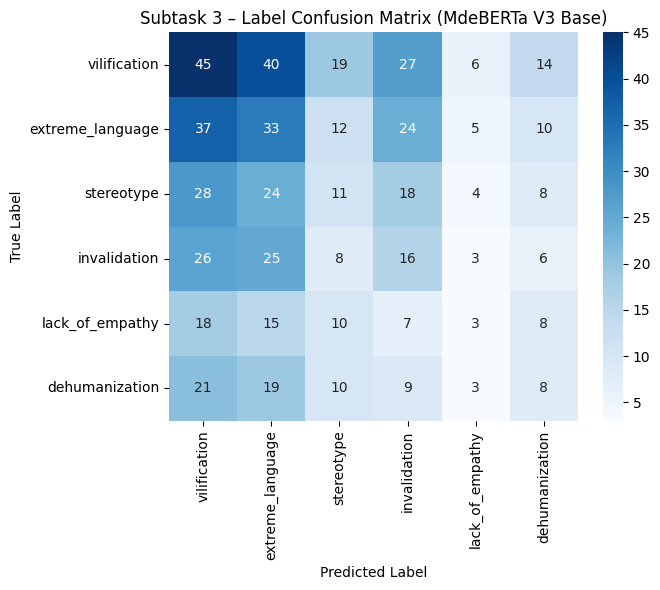

In [26]:
# Validation predictions
val_preds_t3 = trainer_task3.predict(val_dataset_t3)

# Sigmoid + threshold
probs_t3 = torch.sigmoid(torch.from_numpy(val_preds_t3.predictions))
y_pred_t3 = (probs_t3 > 0.5).int().numpy()
y_true_t3 = val_preds_t3.label_ids

labels_t3 = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
naming='MdeBERTa_V3_Base_t2'
title='MdeBERTa V3 Base'
plot_label_confusion_matrix_multilabel(
    y_true_t3,
    y_pred_t3,
    labels_t3,
    naming,
    title=f"Subtask 3 – Label Confusion Matrix ({title})"
)
